In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


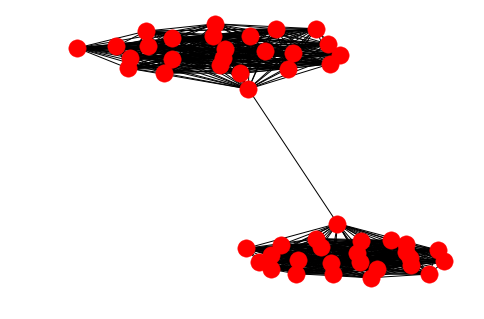

In [2]:
num_each = 50
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 8
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [3]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            lambda[k,:] ~ gamma(a,b);
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [4]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51a05d3382364f39c56e2a47babb486a NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp_m7bp0lk/stanfit4anon_model_51a05d3382364f39c56e2a47babb486a_6876064339324291990.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [25]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=10000, chains=1)

In [26]:
fit

Inference for Stan model: anon_model_51a05d3382364f39c56e2a47babb486a.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1,1]       0.11  1.4e-3   0.09 4.2e-3   0.04    0.1   0.17   0.31   4052    1.0
pi[2,1]       0.03  3.7e-4   0.03 6.4e-4 8.2e-3   0.02   0.04    0.1   5549    1.0
pi[3,1]       0.03  3.3e-4   0.03 8.1e-4 7.7e-3   0.02   0.04    0.1   6404    1.0
pi[4,1]       0.02  2.8e-4   0.02 6.1e-4 6.4e-3   0.02   0.03   0.08   6388    1.0
pi[5,1]       0.02  2.4e-4   0.02 5.8e-4 5.8e-3   0.01   0.03   0.07   6935    1.0
pi[6,1]       0.96  4.3e-4   0.03   0.87   0.95   0.97   0.99    1.0   6582    1.0
pi[7,1]       0.95  6.2e-4   0.05   0.83   0.93   0.96   0.99    1.0   6183    1.0
pi[8,1]       0.95  5.5e-4   0.05   0.83   0.93   0.97   0.99    1.0   6858    1.0
pi[9,1]       0.95  6.1e-4   0.05   0.83   0.93   0.97   0.99  

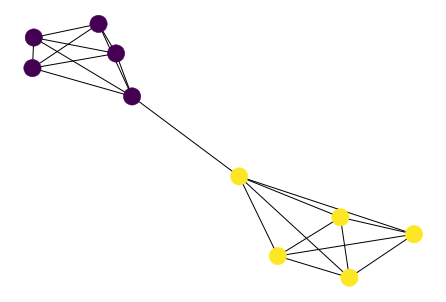

In [27]:
pi = fit.extract()["pi"]
groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


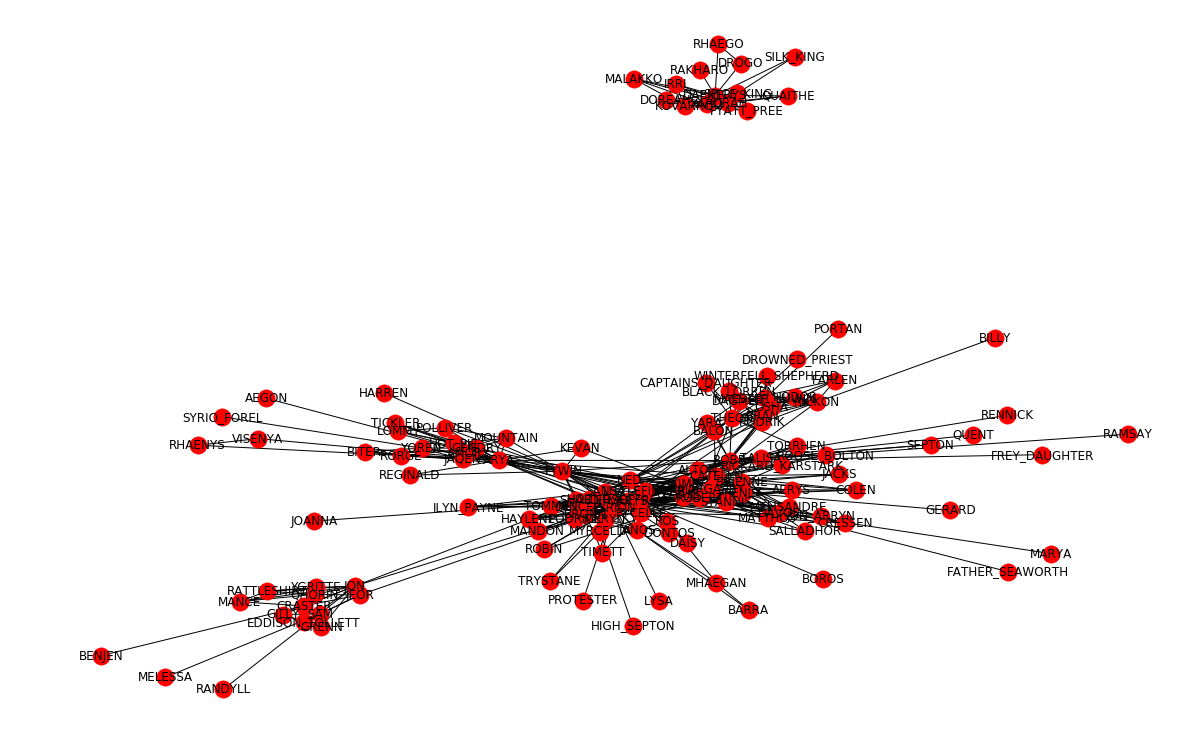

In [5]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s2-nodes.csv')
edges = pd.read_csv('../data/got-s2-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,10))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [6]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha

In [ ]:
%%time
n = graph.shape[0]
k = 5
alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : 3*k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1}
fit1 = sm.sampling(data=data, iter=5000, chains=1)

In [12]:
pi = fit.extract()["pi"]

NameError: name 'fit' is not defined

In [ ]:
groups = np.argmax(pi[-3],axis = 1)

In [ ]:
fit

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)